# ePSproc Matlab demo

As noted in the [main readme/intro doc](../about.html), ePSproc originally started as a set of Matlab routines, before migration to Python in 2019. Although no longer maintained/updated since ~2018, the Matlab routines are still available as part of the ePSproc distribution. This notebook demos the routines, following the demo script `ePSproc_NO2_MFPADs_demo.m` (to run this code in a Jupyter environment, a Matlab kernel is required, e.g. [Calysto's Matlab kernel](https://github.com/Calysto/matlab_kernel)).

Functionality:

* Read raw photoionization matrix elements from ePS output files with “dumpIdy” segments
* Calculate MF-PADs from the matrix elements (ePSproc_MFPAD.m, see also ePSproc_NO2_MFPADs_demo.m)
* Plot MF-PADs
* Plot X-sects
* (Beta testing): Calculate MF-BLMs from matrix elements, see ePSproc_MFBLM.m
* (Under development): Calculate AF-BLMs from matrix elements.


Source:

* /matlab: stable matlab code (as per `release v1.0.1 <https://github.com/phockett/ePSproc/releases>`__).

  * a set of functions for processing (ePSproc*.m files)
  * a script showing demo calculations, `ePSproc_NO2_MFPADs_demo.m`


* /docs/additional contains:

  * the benchmark results from these calculations, `ePSproc_NO2_testing_summary_250915.pdf`
  * additional notes on ePS photoionization matrix elements, `ePSproc_scattering_theory_ePS_notes_011015.pdf`.

See `ePSproc: Post-processing suite for ePolyScat electron-molecule scattering calculations <https://www.authorea.com/users/71114/articles/122402/_show_article>`_ for more details.

## Setup

In [1]:
cd('~/github/ePSproc')  % Change to ePSproc root dir.


ans =

    '9.4.0.813654 (R2018a)'



In [2]:
%% *** SETTINGS
%  Set up basic environment

% Name & path to ePS output file. In this version set full file name here, and working directory below.
% fileName='no2_demo_ePS.out'  % OK for MFPAD testing, but only single E point
fileName='n2_3sg_0.1-50.1eV_A2.inp.out'

% Set paths for Linux or Win boxes (optional!)
if isunix
    dirSlash='/';
else
    dirSlash='\';
end

filePath=[pwd dirSlash 'data' dirSlash 'photoionization'];                       % Root to working directory, here set as current dir/data/photoionization
fileBase=[filePath dirSlash fileName];   % Full path to ePS results file, here set as current working direcory

scriptPath=[pwd dirSlash 'matlab' dirSlash];  % Add path to ePSproc scrips to Matlab path list, here set as current dir/matlab
path(path,[scriptPath]);   


fileName =

    'n2_3sg_0.1-50.1eV_A2.inp.out'



In [3]:
%% *** Read data
%  Variables:
%       rlAll contains matrix elements (from DumpIdy segments)
%       params contains various calculation parameters
%       getCro contains cross-section (from GetCro segments), if present

[rlAll, params, getCro]=ePSproc_read(fileBase);

params.fileBase=fileBase;
params.fileName=fileName;

*** Reading ePS output file
/home/paul/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out
Found 102 sets of matrix elements
Read 102 sets of matrix elements (0 blank records)
Found 2 symmetries
    'SU'    'PU'

Found 51 energies
Found 2 atoms
Found 18 data records
Found 3 sets of cross sections


In [36]:
% Matrix elements are stored in a structure
rlAll


rlAll = 

  2x51 struct array with fields:

    eKE
    PE
    symm
    symmSet
    MbNorm
    rawIdyHead
    rawIdy1
    rlnlHead
    rlnl1
    rawIdy2
    rlnl2
    pWaveAll



In [37]:
% GetCro outputs (total cross-secions, LF betas)
getCro


getCro = 

  1x3 struct array with fields:

    GetCro



In [38]:
% General calculation params
params


params = 

  struct with fields:

        symmList: {'SU'  'PU'  'All'}
             eKE: [1x51 double]
         symmAll: {1x102 cell}
            eAll: [1x102 double]
        nRecords: 102
       nEnergies: 51
          nSymms: 2
           gLmax: 11
        blankRec: 0
        missingE: [1x0 double]
        pWaveAll: [144x51x3 double]
      pWaveAllMb: [144x51x3 double]
        LMallInd: [144x2 double]
          coords: {1x5 cell}
     dataRecords: {18x2 cell}
              IP: 15.5800
    GetCroHeader: {{1x1 cell}}
        fileBase: '/home/paul/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out'
        fileName: 'n2_3sg_0.1-50.1eV_A2.inp.out'



## Plot cross-sections and betas

These are taken from the `GetCro` segments in the ePS output files, and correspond to results for an isotropic ensemble of molecules, i.e. observables in the lab frame (LF) for 1-photon ionization (see [the ePS tutorial for more details](https://epsproc.readthedocs.io/en/latest/ePS_ePSproc_tutorial/ePS_tutorial_080520.html#Theoretical-background)).


> In legend>set_children_and_strings (line 646)
  In legend>make_legend (line 316)
  In legend (line 259)


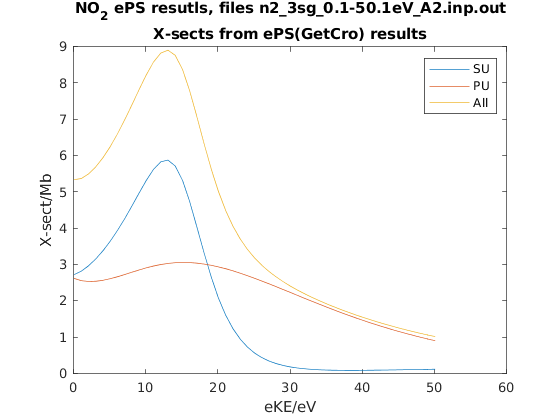

In [4]:
%% Plot GetCro results for each symm & total

col=2;  % Select column from getCro output (see params.GetCroHeader)

figure('color',[1 1 1],'name','GetCro outputs');

for n=1:length(getCro)
    plot(getCro(n).GetCro(:,1)-params.IP,getCro(n).GetCro(:,col));
    hold on;
end

title({['NO_2 ePS resutls, files ' strrep(fileName,'_','\_')]; 'X-sects from ePS(GetCro) results'});
xlabel('eKE/eV');
ylabel('X-sect/Mb');

legend([params.symmList 'Sum']);

## MFPADs

These are calculated numerically from the matrix elements, for a given polarization geometry and symmetry (the [method is the same as the python version of the routine](https://epsproc.readthedocs.io/en/dev/demos/ePSproc_demo_Aug2019.html#Calculate-MFPADs)).

In [16]:
%% *** Calculate MFPADs - single polarization geometry, all energies and symmetries
%  Calculate for specified Euler angles (polarization geometry) & energies

% Set resolution for calculated I(theta,phi) surfaces
res=100;

% ip components to use from ePS output (1=length gauge, 2=velocity gauge)
ipComponents=1;

% it components to use from ePS output (for degenerate cases), set an array here for as many components as required, e.g. it=1, it=[1 2] etc.
it=1;

% Set light polarization and axis rotations LF -> MF
p=0;                % p=0 for linearly pol. light, +/-1 for L/R circ. pol.
eAngs=[0 0 0];      % Eugler angles for rotation of LF->MF, set as [0 0 0] for z-pol, [0 pi/2 0] for x-pol, [pi/2 pi/2 0] for y-pol
polLabel='z';

% Run calculation - outputs are D, full set of MFPADs (summed over symmetries); Xsect, calculated X-sects; calcsAll, structure with results for all symmetries.
[Xsect, calcsAll, pWaves]=ePSproc_MFPAD(rlAll,p,eAngs,it,ipComponents,res);

% Add pol labels - currently expected in plotting routine, but not set in MFPAD routine
for n=1:size(calcsAll,2)
    for symmIn=1:size(calcsAll,1)
        calcsAll(symmInd,n).polLabel=polLabel;
    end
end
        

In [6]:
% Results are output as a structure, dims (symmetries, energies).
calcsAll


calcsAll = 

  3x51 struct array with fields:

    D
    C
    Cthres
    eKE
    symm
    euler
    Xsect
    XsectD
    Rlf
    p
    Cind



In [18]:
%plot -s 800,400

(Above is a line-magic for setting displayed plot size with the Calysto kernel - see [the demo notebook](https://nbviewer.jupyter.org/github/Calysto/matlab_kernel/blob/master/matlab_kernel.ipynb) for more.)

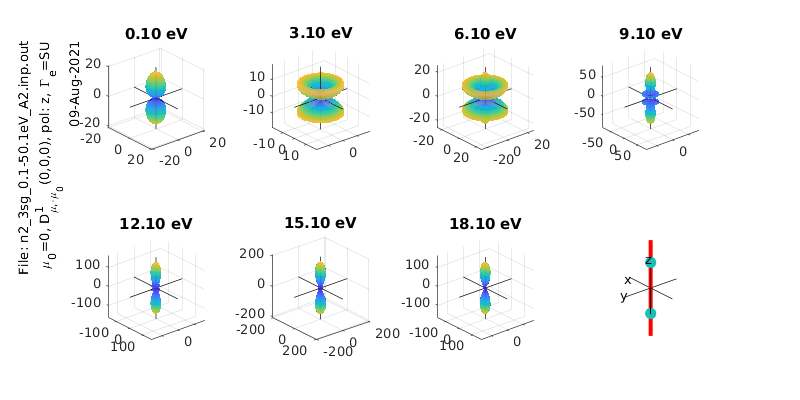

In [19]:
%% Plotting - MFPAD panel plots

% Set plot ranges
symmInd=1;     % Select symmetry (by index into calcsAll rows). Final symmetry state is set as sum over all symmetries
% eRange=1;      % Select energies (by index into calcsAll cols)
eRange=1:3:20;

% Additional options (optional)
sPlotSet=[2 4];             % Set [rows cols] for subplot panels. The final panel will be replaced with a diagram of the geometry
% titlePrefix='NO2 testing';  % Set a title prefix for the figure
titlePrefix='';

ePSproc_MFPAD_plot(calcsAll,eRange,symmInd,params,sPlotSet,titlePrefix);
% ePSproc_MFPAD_plot(calcsAll,eRange,symmInd,params,sPlotSet,'','n','off');
% ePSproc_MFPAD_plot(calcsAll,eRange,symmInd,params,[2 4],'','n','off');


symmInd =

     3



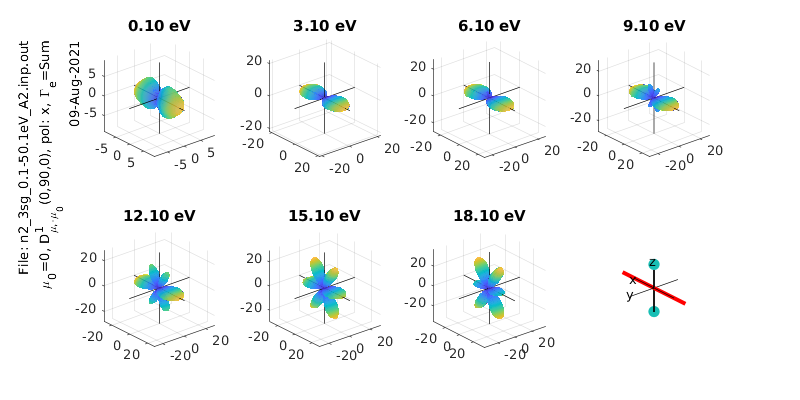

In [22]:
% Calculate & plot for a different polarization state
eAngs = [0 pi/2 0];  % x-pol case
polLabel = 'x';

[Xsect, calcsAll, pWaves]=ePSproc_MFPAD(rlAll,p,eAngs,it,ipComponents,res);

% Add pol labels - currently expected in plotting routine, but not set in MFPAD routine
for n=1:size(calcsAll,2)
    for symmIn=1:size(calcsAll,1)
        calcsAll(symmInd,n).polLabel=polLabel;
    end
end

symmInd=3;
ePSproc_MFPAD_plot(calcsAll,eRange,symmInd,params,sPlotSet,titlePrefix);

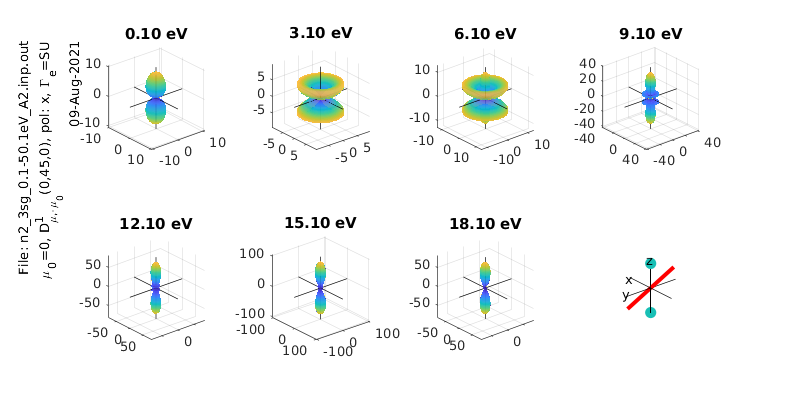

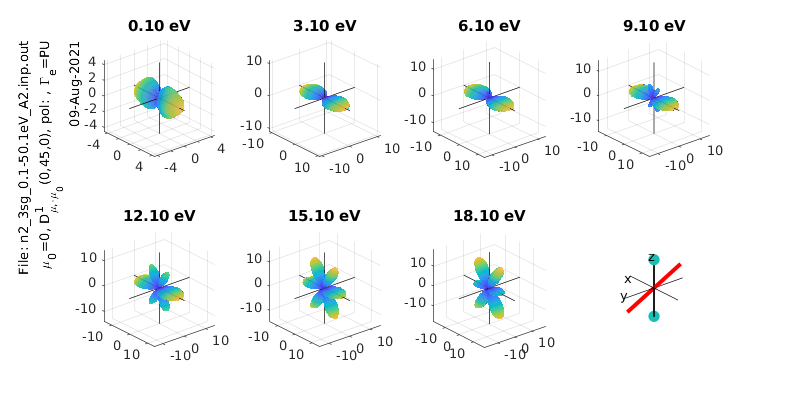

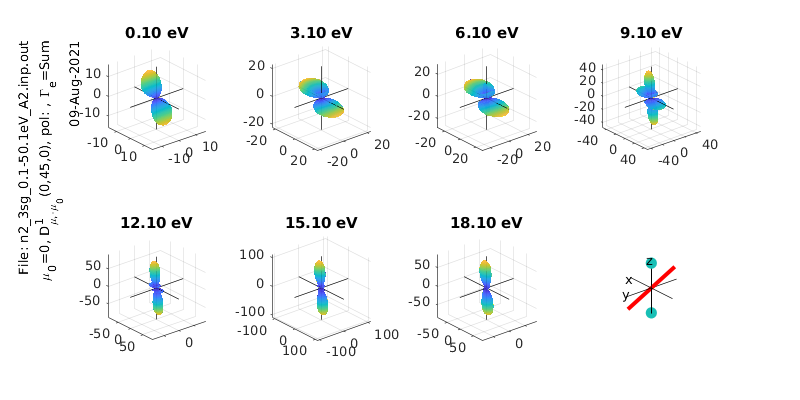

In [21]:
% Calculate & plot for a different polarization state
eAngs = [0 pi/4 0];  % Diagonal pol case
polLabel = 'x';

[Xsect, calcsAll, pWaves]=ePSproc_MFPAD(rlAll,p,eAngs,it,ipComponents,res);

% Add pol labels - currently expected in plotting routine, but not set in MFPAD routine
for n=1:size(calcsAll,2)
    for symmIn=1:size(calcsAll,1)
        calcsAll(symmInd,n).polLabel=polLabel;
    end
end

% Plot all symmetries
for symmInd = 1:3
    ePSproc_MFPAD_plot(calcsAll,eRange,symmInd,params,sPlotSet,titlePrefix);
    
end

## MF $\beta_{LM}$

In [25]:
%% *** Calculate MFPADs - single polarization geometry, all energies and symmetries
%  Calculate for specified Euler angles (polarization geometry) & energies

% Set resolution for calculated I(theta,phi) surfaces
res=100;

% ip components to use from ePS output (1=length gauge, 2=velocity gauge)
ipComponents=1;

% it components to use from ePS output (for degenerate cases), set an array here for as many components as required, e.g. it=1, it=[1 2] etc.
it=1;

% Set light polarization and axis rotations LF -> MF
p=0;                % p=0 for linearly pol. light, +/-1 for L/R circ. pol.
eAngs=[0 0 0];      % Eugler angles for rotation of LF->MF, set as [0 0 0] for z-pol, [0 pi/2 0] for x-pol, [pi/2 pi/2 0] for y-pol
polLabel='z';

% Run calculation - outputs are D, full set of MFPADs (summed over symmetries); Xsect, calculated X-sects; calcsAll, structure with results for all symmetries.
calcsAll=ePSproc_MFPAD(rlAll,p,eAngs,it,ipComponents,res);

% Add pol labels - currently expected in plotting routine, but not set in MFPAD routine
% for n=1:size(calcsAll,2)
%     for symmIn=1:size(calcsAll,1)
%         calcsAll(symmInd,n).polLabel=polLabel;
%     end
% end
        

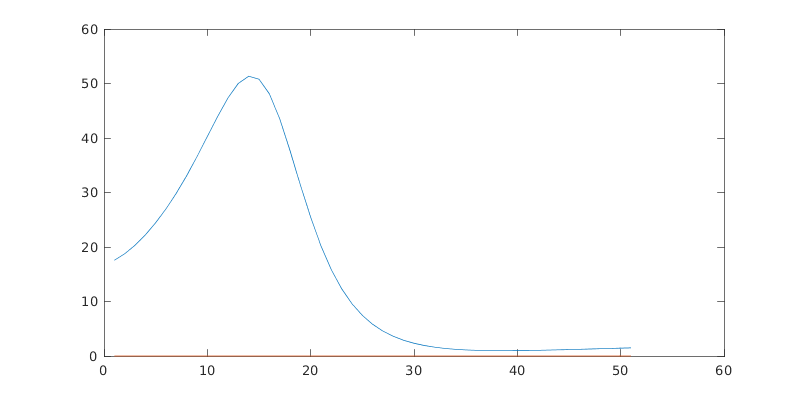

In [34]:
plot(calcsAll.')